# Pretrained GAN

In [1]:
import fastai
from fastai import *
from fastai.vision import *
from fastai.callbacks import *

from torchvision.models import vgg16_bn

In [2]:
path = untar_data(URLs.PETS)
path_hr = path/'images'
path_lr = path/'crappy'

In [3]:
torch.cuda.set_device(2)

## Critic data

Prepare the input data by crappifying images.

In [4]:
def crappify(fn,i):
    dest = path_lr/fn.relative_to(path_hr)
    dest.parent.mkdir(parents=True, exist_ok=True)
    img = PIL.Image.open(fn)
    targ_sz = resize_to(img, 96, use_min=True)
    img = img.resize(targ_sz, resample=PIL.Image.BILINEAR).convert('RGB')
    img.save(dest, quality=random.randint(10,70))

Uncomment the first time you run this notebook.

In [5]:
#il = ImageItemList.from_folder(path_hr)
#parallel(crappify, il.items)

For gradual resizing we can change the commented line here.

In [6]:
#bs,size = 32,128
#bs,size = 8,256
bs,size = 16,160
arch = models.resnet34
classes = ['crappy', 'images']
src = ImageItemList.from_folder(path, include=classes).random_split_by_pct(0.1, seed=42)

In [7]:
ll = src.label_from_folder(classes=classes)

In [8]:
data_crit = (ll.transform(get_transforms(max_zoom=2.), size=size)
       .databunch(bs=bs).normalize(imagenet_stats))

data_crit.c = 3

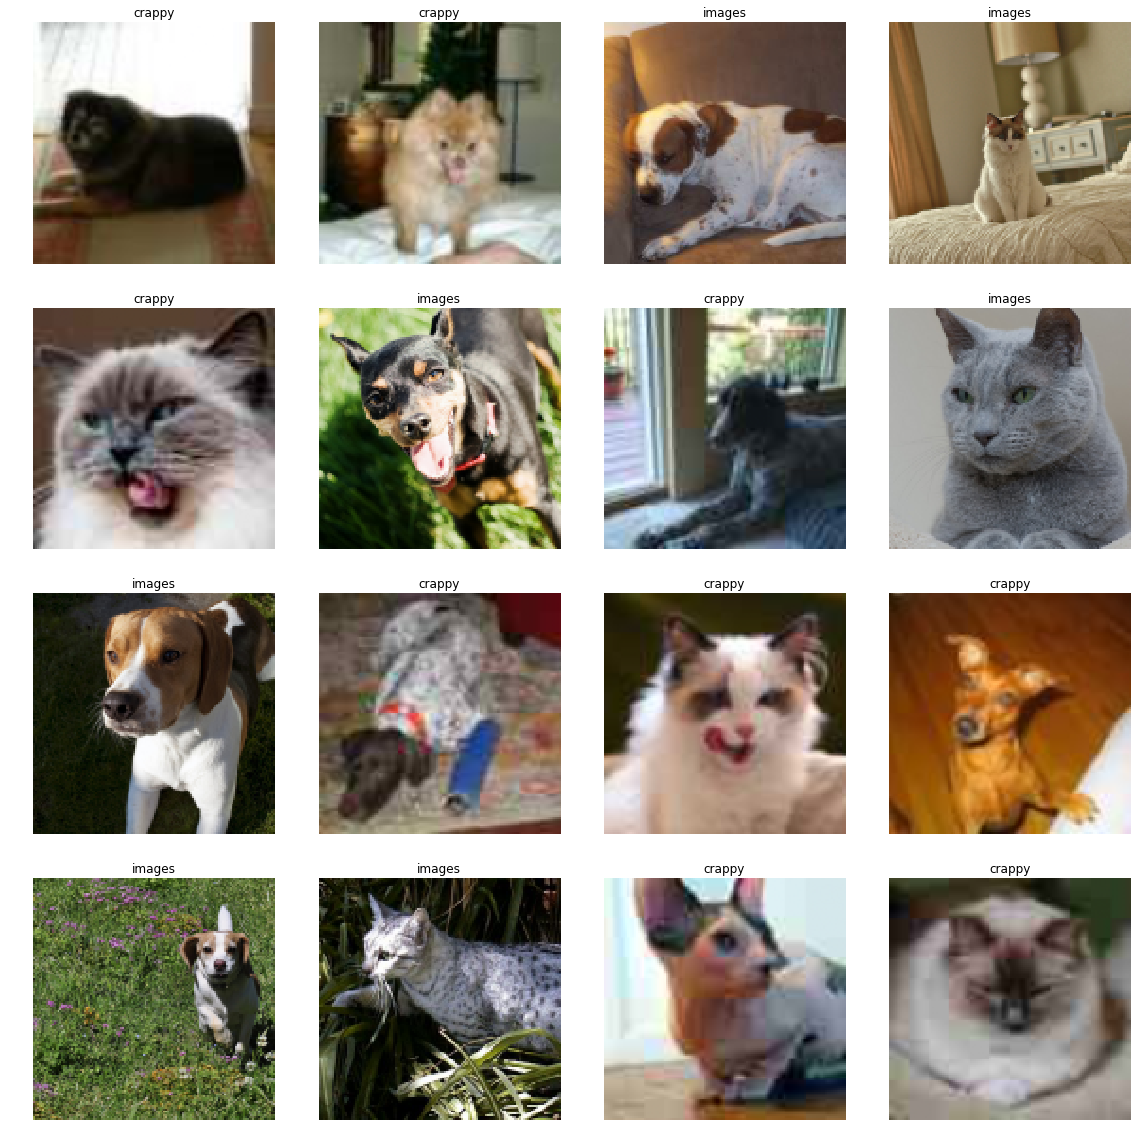

In [9]:
data_crit.show_batch(rows=4, ds_type=DatasetType.Valid)

## Train critic

In [9]:
conv_args = dict(leaky=0.2, norm_type=NormType.Spectral)

def conv(ni:int, nf:int, ks:int=3, stride:int=1, **kwargs):
    return conv_layer(ni, nf, ks=ks, stride=stride, **conv_args, **kwargs)

def critic(n_channels:int=3, nf:int=128, n_blocks:int=3, p:int=0.25):
    layers = [
        conv(n_channels, nf, ks=4, stride=2),
        nn.Dropout2d(p/2),
        # Removing conv_args because spectral norm makes this slow
        res_block(nf, dense=True)] # , **conv_args)]
    nf *= 2 # after dense block
    for i in range(n_blocks):
        layers += [
            nn.Dropout2d(p),
            conv(nf, nf*2, ks=4, stride=2, self_attention=(i==0))]
        nf *= 2
    layers += [
        conv(nf, 1, ks=4, bias=False, padding=0, use_activ=False),
        Flatten()]
    return nn.Sequential(*layers)

Module to apply the loss function to every element of the last features before taking the mean.

In [10]:
class AdaptiveLoss(nn.Module):
    def __init__(self, crit):
        super().__init__()
        self.crit = crit

    def forward(self, output, target):
        return self.crit(output, target[:,None].expand_as(output).float())

Specific accuracy metric.

In [11]:
def accuracy_thresh_expand(y_pred:Tensor, y_true:Tensor, thresh:float=0.5, sigmoid:bool=True)->Rank0Tensor:
    "Compute accuracy when `y_pred` and `y_true` are the same size."
    if sigmoid: y_pred = y_pred.sigmoid()
    return ((y_pred>thresh)==y_true[:,None].expand_as(y_pred).byte()).float().mean()

Pretrain the critic on crappy vs not crappy.

In [12]:
learn_critic = Learner(data_crit, critic(), metrics=accuracy_thresh_expand, loss_func=AdaptiveLoss(nn.BCEWithLogitsLoss()))

In [13]:
learn_critic.fit_one_cycle(6, 1e-3)

epoch,train_loss,valid_loss,accuracy_thresh_expand
1,0.330080,0.164106,0.943347
2,0.140111,0.061365,0.986176
3,0.088078,0.511824,0.929050
4,0.060350,0.020491,0.997482
5,0.028298,0.010954,0.998595
6,0.046121,0.008129,0.998715


In [14]:
learn_critic.save('critic-pre2')

## Pre-train generator

Now let's pretrain the generator.

In [12]:
arch = models.resnet34
src = ImageImageList.from_folder(path_lr).random_split_by_pct(0.1, seed=42)

In [13]:
def get_data(bs,size):
    data = (src.label_from_func(lambda x: path_hr/x.name)
           .transform(get_transforms(max_zoom=2.), size=size, tfm_y=True)
           .databunch(bs=bs).normalize(imagenet_stats))

    data.c = 3
    return data

In [14]:
data_gen = get_data(bs,size)

In [15]:
wd = 1e-3

In [25]:
learn_gen = unet_learner(data_gen, arch, wd=wd, blur=True, norm_type=NormType.Spectral, self_attention=True, sigmoid=True,
                         loss_func=MSELossFlat())

In [26]:
learn_gen.fit_one_cycle(2, pct_start=0.8)

epoch,train_loss,valid_loss
1,0.003994,0.002930
2,0.002630,0.002628


In [27]:
learn_gen.unfreeze()

In [28]:
learn_gen.fit_one_cycle(2, slice(1e-6,1e-3))

epoch,train_loss,valid_loss
1,0.002551,0.002525
2,0.002466,0.002473


In [33]:
data_gen = get_data(bs,size)
learn_gen.data = data_gen

In [34]:
learn_gen.fit_one_cycle(2, slice(1e-6,1e-3))

epoch,train_loss,valid_loss
1,0.001837,0.001962
2,0.001734,0.001859


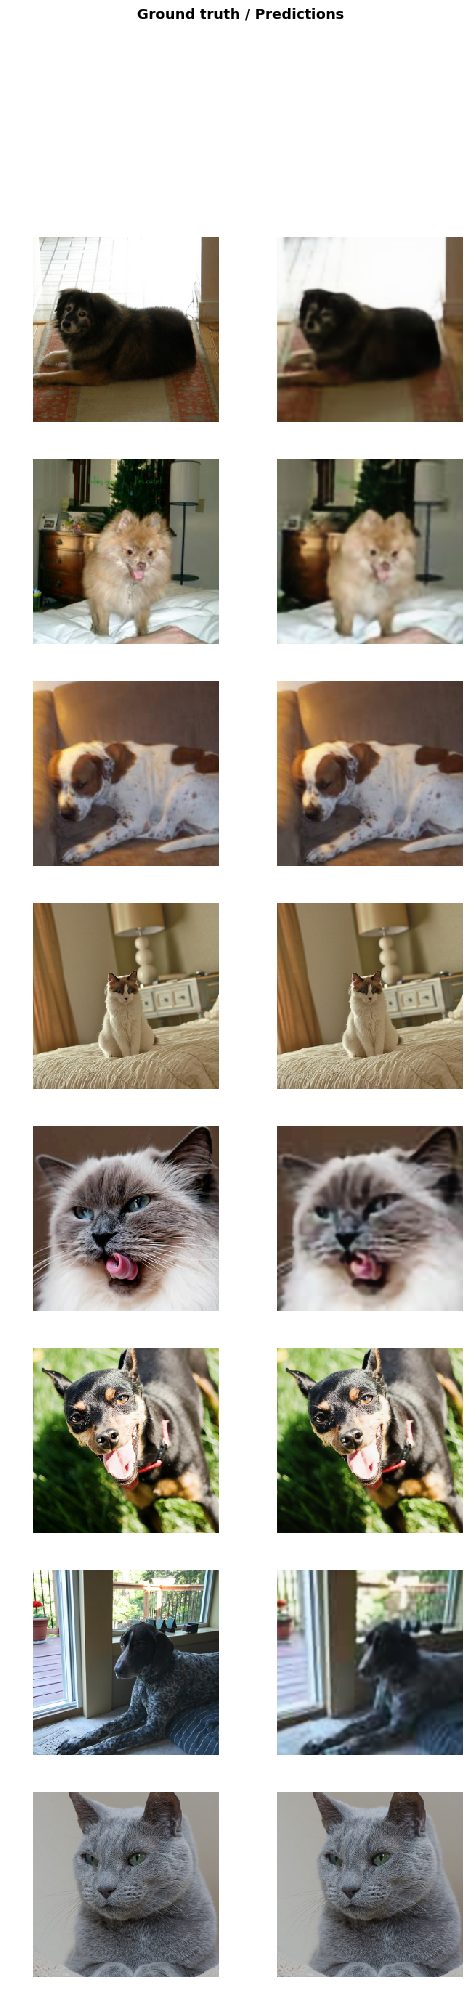

In [35]:
learn_gen.show_results(rows=8)

In [36]:
learn_gen.save('gen-pre2')

## GAN

Now we'll combine those pretrained model in a GAN.

In [16]:
from fastai.vision.gan import *

Those are the losses from before.

In [17]:
loss_critic = AdaptiveLoss(nn.BCEWithLogitsLoss())
loss_gen    = MSELossFlat()

In [18]:
learn_crit = Learner(data_crit, critic(), loss_func=loss_critic).load('critic-pre2')

In [ ]:
learn_gen = unet_learner(data_gen, arch, wd=wd, blur=True, norm_type=NormType.Spectral, self_attention=True, sigmoid=True,
                         loss_func=MSELossFlat()).load('gen-pre2')

To define a GAN Learner, we just have to specify the learner objects foor the generator and the critic. The switcher is a callback that decides when to switch from discriminator to generator and vice versa. Here we do as many iterations of the discriminator as needed to get its loss back < 0.5 then one iteration of the generator.

The loss of the critic is given by `learn_crit.loss_func`. We take the average of this loss function on the batch of real predictions (target 1) and the batch of fake predicitions (target 0). 

The loss of the generator is weighted sum (weights in `weights_gen`) of `learn_crit.loss_func` on the batch of fake (passed throught the critic to become predictions) with a target of 1, and the `learn_gen.loss_func` applied to the output (batch of fake) and the target (corresponding batch of superres images).

In [20]:
@dataclass
class GANDiscriminativeLR(LearnerCallback):
    "`Callback` that handles multiplying the learning rate by `mult_lr` for the critic."
    mult_lr:float = 1.

    def on_batch_begin(self, train, **kwargs):
        "Multiply the current lr if necessary."
        if not self.learn.gan_trainer.gen_mode and train:
            self.learn.opt.lr *= self.mult_lr

    def on_step_end(self, **kwargs):
        "Put the LR back to its value if necessary."
        if not self.learn.gan_trainer.gen_mode:
            self.learn.opt.lr /= self.mult_lr

In [21]:
#switcher = partial(AdaptiveGANSwitcher, critic_thresh=0.5)
switcher = partial(FixedGANSwitcher, n_crit=1, n_gen=1)
learn = GANLearner.from_learners(learn_gen, learn_crit, weights_gen=(1.,250.), show_img=False, switcher=switcher,
                                 opt_func=partial(optim.Adam, betas=(0.,0.99)), wd=0)
learn.callback_fns.append(partial(GANDiscriminativeLR, mult_lr=5.))

In [ ]:
learn.fit(20,1e-4)

epoch,train_loss,gen_loss,disc_loss


In [22]:
learn.fit(20,1e-4)

epoch,train_loss,gen_loss,disc_loss
1,1.898160,1.677853,3.540568
2,1.371570,1.288713,2.744730
3,1.113121,1.387647,2.335821
4,0.932278,0.633096,2.222496
5,0.839472,0.640734,2.200231
6,0.908061,0.895778,2.253215
7,0.816093,1.084147,2.200729
8,0.902895,0.664972,2.229367
9,0.983163,1.285665,2.236639
10,0.975240,0.656381,2.230612


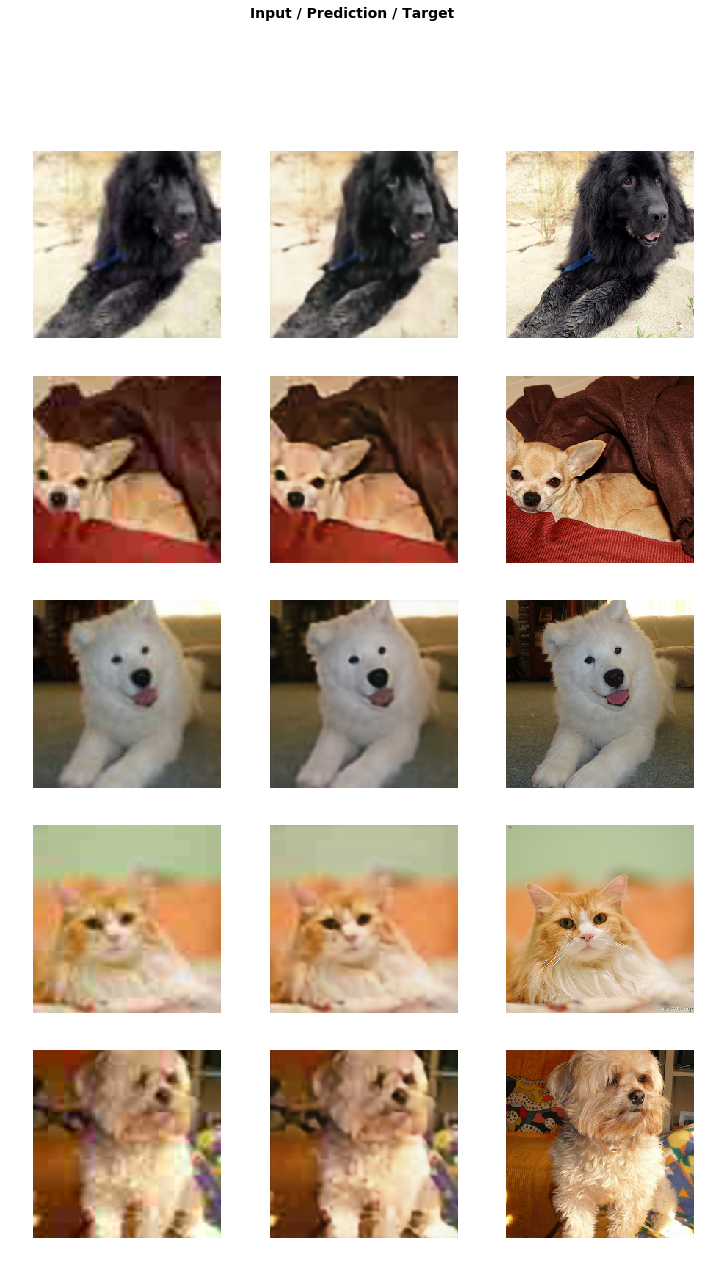

In [33]:
#Without dense block, adaptive schedule
learn.show_results()

## fin